In [132]:
#import pandas as pd

#df_full = pd.read_csv('data\\steam_reviews.csv')

#apps = df_full.groupby('app_name').size()

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [134]:
# Read csv, pick Team Fortress 2 as the game to analyze and keep relevant columns.

df_full = pd.read_csv('data\\steam_reviews.csv', index_col=0)

df = df_full[df_full['app_name'] == 'Team Fortress 2']
df = df.drop('review_votes', axis=1)

df.head()

,app_name,review_text,review_score
app_id,,,
440,Team Fortress 2,My hours. help. I wrote something for real! ...,1
440,Team Fortress 2,This is the cycle of every Team Fortress 2...,1
440,Team Fortress 2,It's good.,1
440,Team Fortress 2,"If you bind forward to a button on your mouse,...",1
440,Team Fortress 2,The vicious cycle of Team fortress 2 First wh...,1


In [135]:
# Check number of reviews per score.

df.groupby(['app_name', 'review_score']).size()

app_name         review_score
Team Fortress 2  -1               1483
                  1              10737
dtype: int64

In [136]:
# Balance the df based on review_score to make the future models evaluation metrics clearer.

g = df.groupby('review_score')
df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min())).reset_index(drop=True))
df.groupby(['app_name', 'review_score']).size()

app_name         review_score
Team Fortress 2  -1              1483
                  1              1483
dtype: int64

Review mean length:
review_score
-1    558.960890
 1    286.355361
Name: review_length, dtype: float64


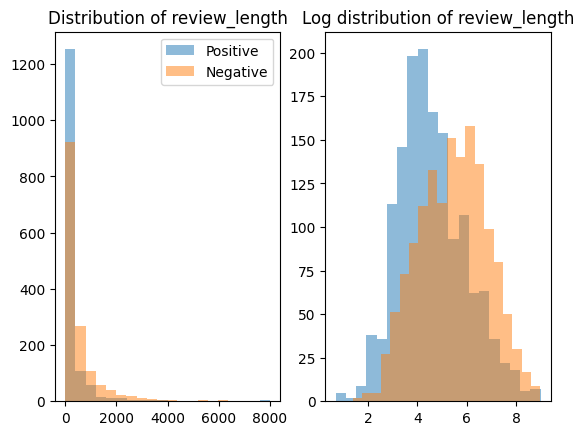

In [137]:
# Print the mean lengths of review_text per review_score.
# Plot the distributions of the lengths.

def len_str(text):
    return len(str(text))

df['review_length'] = df['review_text'].apply(len_str)

mean_review_length = df.groupby('review_score')['review_length'].mean()
print(f'Review mean length:\n{mean_review_length}')

df['review_length_log'] = df['review_length'].apply(math.log)

positive = df[df['review_score'] == 1]
negative = df[df['review_score'] == -1]

fig, axs = plt.subplots(1, 2)
axs[0].hist(positive['review_length'], alpha=0.5, bins=20, label='Positive')
axs[0].hist(negative['review_length'], alpha=0.5, bins=20, label='Negative')
axs[1].hist(positive['review_length_log'], alpha=0.5, bins=20, label='Positive')
axs[1].hist(negative['review_length_log'], alpha=0.5, bins=20, label='Negative')
axs[0].title.set_text('Distribution of review_length')
axs[1].title.set_text('Log distribution of review_length')
axs[0].legend()
plt.show()

In [138]:
# Credit for this cell to https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained

# Clean the column review_text and create a new column with the result.

import re
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df['review_clean'] = df['review_text'].apply(clean_text)
df.head()

,app_name,review_text,review_score,review_length,review_length_log,review_clean
0,Team Fortress 2,Holy ♥♥♥♥♥ they tried to make this game compet...,-1,123,4.812184,holy ♥♥♥♥♥ they tried to make this game compet...
1,Team Fortress 2,go play day of defeat or counter strike instea...,-1,74,4.304065,go play day of defeat or counter strike instea...
2,Team Fortress 2,WE WANT QUICKPLAY BACK!!!! Ever since tf2 has...,-1,120,4.787492,we want quickplay back ever since has added ...
3,Team Fortress 2,Newest Update Killed quick Play and Possibly K...,-1,55,4.007333,newest update killed quick play and possibly k...
4,Team Fortress 2,I loved this game. Loved. This game has sadly ...,-1,2487,7.818832,i loved this game loved this game has sadly lo...


In [139]:
# Credit for this cell to https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained

# Remove english stopwords from column 'review_clean' with the function remove_stopwords

import stopwords

stop_words = stopwords.get_stopwords('english')
more_stopwords = ['play', 'game', 'arma', 'will']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

df['review_clean'] = df['review_clean'].apply(remove_stopwords)
df.head()

,app_name,review_text,review_score,review_length,review_length_log,review_clean
0,Team Fortress 2,Holy ♥♥♥♥♥ they tried to make this game compet...,-1,123,4.812184,holy ♥♥♥♥♥ tried make competitive now lost fun...
1,Team Fortress 2,go play day of defeat or counter strike instea...,-1,74,4.304065,go day defeat counter strike instead see negat...
2,Team Fortress 2,WE WANT QUICKPLAY BACK!!!! Ever since tf2 has...,-1,120,4.787492,want quickplay back ever since added casual co...
3,Team Fortress 2,Newest Update Killed quick Play and Possibly K...,-1,55,4.007333,newest update killed quick possibly killed
4,Team Fortress 2,I loved this game. Loved. This game has sadly ...,-1,2487,7.818832,loved loved sadly long since surpassed glory d...


In [140]:
# Credit for this cell to https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained

# Stemm the words in column 'review_clean' with the function stemm_text

import nltk

stemmer = nltk.SnowballStemmer('english')

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

df['review_clean'] = df['review_clean'].apply(stemm_text)
df.head()

,app_name,review_text,review_score,review_length,review_length_log,review_clean
0,Team Fortress 2,Holy ♥♥♥♥♥ they tried to make this game compet...,-1,123,4.812184,holi ♥♥♥♥♥ tri make competit now lost fun wont...
1,Team Fortress 2,go play day of defeat or counter strike instea...,-1,74,4.304065,go day defeat counter strike instead see negat...
2,Team Fortress 2,WE WANT QUICKPLAY BACK!!!! Ever since tf2 has...,-1,120,4.787492,want quickplay back ever sinc ad casual comp j...
3,Team Fortress 2,Newest Update Killed quick Play and Possibly K...,-1,55,4.007333,newest updat kill quick possibl kill
4,Team Fortress 2,I loved this game. Loved. This game has sadly ...,-1,2487,7.818832,love love sad long sinc surpass glori day show...


In [141]:
# Create a column 'review_score_target' with 0 and 1 as values instead of -1 and 1 which can be found in 'review_score'.
# Create x and y variables to be used for modeling and double check that their sizes are equal.

def targetEncoded(toEncode):
    return 1 if toEncode == 1 else 0

df['review_score_target'] = df['review_score'].apply(targetEncoded)

x = df['review_clean']
y = df['review_score_target']

print(f'{len(x) = }, {len(y) = }')
df.groupby(['review_score', 'review_score_target']).size()

len(x) = 2966, len(y) = 2966


review_score  review_score_target
-1            0                      1483
 1            1                      1483
dtype: int64

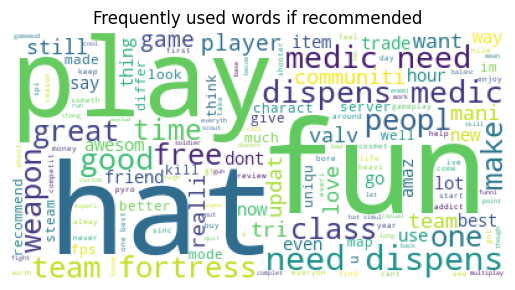

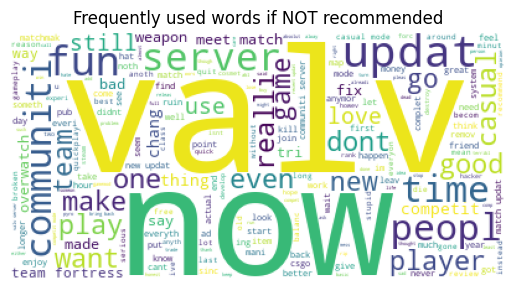

In [142]:
# Make wordclouds for words used in recommended reviews and not recommended reviews

from wordcloud import WordCloud

wc = WordCloud(background_color='white', max_words=200)

wc.generate(' '.join(text for text in df.loc[df['review_score_target'] == 1, 'review_clean']))
plt.axis('off')
plt.title('Frequently used words if recommended')
plt.imshow(wc)
plt.show()

wc.generate(' '.join(text for text in df.loc[df['review_score_target'] == 0, 'review_clean']))
plt.axis('off')
plt.title('Frequently used words if NOT recommended')
plt.imshow(wc)
plt.show()

In [143]:
# Split the data into train (75%) and test (25%) sets for the x and y variables.

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

print(f'{len(x_train) = }, {len(y_train) = }')
print(f'{len(x_test) = }, {len(y_test) = }')

len(x_train) = 2224, len(y_train) = 2224
len(x_test) = 742, len(y_test) = 742


In [153]:
from sklearn.feature_extraction.text import CountVectorizer

# Already filtered through stopwords above, but do it again just in case
vect = CountVectorizer(stop_words='english', ngram_range=(1,1), max_features=100)

# Creates a vocabulary dictionary of the top n most frequent words
vect.fit(x_train) 

# Transform the x variables to document term matrices based on the fitted CountVectorizer
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

print(f'Example:\n(Review number, word)   Count\n{x_train_dtm[0]}')

Example:
(Review number, word)   Count
  (0, 0)	1
  (0, 21)	1
  (0, 30)	1
  (0, 34)	1
  (0, 45)	1
  (0, 49)	1
  (0, 79)	1
  (0, 85)	1


In [154]:
# TF-IDF gives higher weights to words that are 
# - rarer across the vocabulary
# - in shorter documents

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)

# Transform the counts to tf-idf values
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

print(f'Example:\n(Review number, word)   TF-IDF\n{x_train_tfidf[0]}')

Example:
(Review number, word)   TF-IDF
  (0, 85)	0.2909123469382167
  (0, 79)	0.35908882277952625
  (0, 49)	0.27202972876522796
  (0, 45)	0.37432406037900506
  (0, 34)	0.28440912601357127
  (0, 30)	0.37030712448145914
  (0, 21)	0.41771291563542357
  (0, 0)	0.4240360255365421


In [155]:
# Get mean weights of all the words and print the highest and lowest means

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_array = pd.DataFrame(x_train_tfidf.toarray(), columns = vect.get_feature_names_out())

tfidf_means = [(tfidf_array[tfidf_array[col] > 0][col].mean(), col) for col in tfidf_array]

print(f'Highest means:\n{sorted(tfidf_means, reverse=True)[:10]}')
print(f'\nLowest means:\n{sorted(tfidf_means, reverse=False)[:10]}')

Highest means:
[(0.4222999772680001, 'hat'), (0.386976720809655, 'best'), (0.3739674152859954, 'free'), (0.36730885689800863, 'dispens'), (0.35875695880135666, 'life'), (0.3316715316952312, 'overwatch'), (0.3201429609180117, 'pub'), (0.31896749911635414, 'fps'), (0.31527773775542894, 'great'), (0.31265433902626905, 'kill')]

Lowest means:
[(0.1792557475917366, 'right'), (0.1838005615061099, 'someth'), (0.19131865876159973, 'point'), (0.19675981191659356, 'leav'), (0.20053874567319613, 'look'), (0.20215907815715203, 'know'), (0.20459300044171416, 'actual'), (0.2046178344330156, 'long'), (0.20480418237057593, 'come'), (0.20573031919105175, 'thing')]


In [147]:
# Train the model and make a prediction on the test set

from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Pick the data set to train on x_train_dtm (count of words) or 
# x_train_tfidf (TF-IDF values of words)
x_train_set = x_train_tfidf

nb.fit(x_train_set, y_train)

# Predict the class for each review
y_pred_class = nb.predict(x_test_dtm)

# Get prediction probabilities for class 1 (review recommends)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]

In [157]:
# Evaluate the prediction results

from sklearn import metrics
from sklearn.metrics import classification_report

print('Model evaluation:\n')
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')
print(f'ROC: {metrics.roc_auc_score(y_test, y_pred_prob)}\n')
print(classification_report(y_test, y_pred_class))
print(f'Confusion matrix:\n[[TN  FP]\n [FN  TP]]\n{metrics.confusion_matrix(y_test, y_pred_class)}')

Model evaluation:

Accuracy: 0.8598382749326146
ROC: 0.9128179932307021

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       387
           1       0.84      0.87      0.86       355

    accuracy                           0.86       742
   macro avg       0.86      0.86      0.86       742
weighted avg       0.86      0.86      0.86       742

Confusion matrix:
[[TN  FP]
 [FN  TP]]
[[330  57]
 [ 47 308]]


In [160]:
print('Words with the highest importance of predicting a recommendation:\nWord Probability')

for word in sorted(list(zip(nb.feature_log_prob_[1], tfidf_transformer.get_feature_names_out(vect.get_feature_names_out()))), reverse=True)[:7]:
    print(f'{word[1]} {round(np.exp(word[0]), 4)}')

print('\nWords with the highest importance of predicting a non-recommendation:\nWord Probability')

for word in sorted(list(zip(nb.feature_log_prob_[0], tfidf_transformer.get_feature_names_out(vect.get_feature_names_out()))), reverse=True)[:7]:
    print(f'{word[1]} {round(np.exp(word[0]), 4)}')


Words with the highest importance of predicting a recommendation:
Word Probability
hat 0.0493
fun 0.0399
best 0.039
good 0.0322
free 0.0307
play 0.0259
great 0.0257

Words with the highest importance of predicting a non-recommendation:
Word Probability
updat 0.0494
valv 0.0375
match 0.0239
server 0.0232
just 0.0231
new 0.0231
casual 0.022


In [42]:
FP = x_test[(y_pred_class == 1) & (y_test == 0)]
FN = x_test[(y_pred_class == 0) & (y_test == 1)]